In [5]:
import matplotlib.pyplot as plt
import os
import theano
import theano.tensor as at
from theano.compile.ops import as_op
import pymc3 as pm
import numpy as np
import fault3d as f3
from matplotlib import cm
pm.set_tt_rng(42)
theano.config.floatX = "float32"
np.random.seed(42)
import pandas as pd

In [2]:
print(
    f"""
# Aesara version: {theano.__version__}
# PyMC version: {pm.__version__}
"""
)


# Aesara version: 1.0.5
# PyMC version: 3.8



In [3]:
inp_file = "data/fault3d.inp"
log_file = "log.txt"

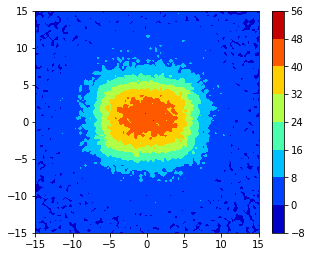

<Figure size 640x480 with 0 Axes>

In [8]:
nx = 90
ny = 90
narea = tuple([-15, 15, -15, 15])
nshape = tuple([nx, ny])
outfile = f3.fault3d.fault(inp_file, log_file, nx, ny)
x = np.linspace(-15, 15, num=90, endpoint=True)
y = np.linspace(-15, 15, num=90, endpoint=True)
xp, yp = np.meshgrid(x, y)

xp = np.array(xp)
yp = np.array(yp)
data = np.array(outfile).flatten()

noise = np.random.normal(0, data.max()*0.05, size=nx*ny)
data = data+noise
v = {
        'x' : list(yp.flatten()),
        'y' : list(xp.flatten()),
        'data' : data,}
v = pd.DataFrame(v)

v.to_csv('gravity_multi.csv')
x = xp.reshape(nx, ny)
y = yp.reshape(nx, ny)
da = data.reshape(nx, ny)
plt.figure(figsize=(5,4),dpi = 72)
plt.contourf(x, y, da, cmap=cm.jet)
plt.colorbar()
plt.show()
plt.savefig("df.png")
obs_data = np.concatenate((da[:, 29],da[:, 50],da[44,:]))

In [5]:
%time
np.savetxt('obs_mu.txt', obs_data, delimiter="\n")

CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 24.1 µs


In [21]:
def make_datafile(v, length1, depth_mid, depth_bottom, dip, cx, cy):
    h2 = depth_mid
    h3 = depth_bottom
    a1 = length1
    da = (h2 - 1)*np.tan(dip*np.pi/180 - np.pi/2)
    a2 = length1 - da
    cx1 = cx
    cx2 = cx1+da/2.0
    theta = dip
    with open('f3d.dat','w') as f:
        f.write('2, 0\n')
        f.write('0.0, 0.0\n')
        f.write(str(v[0])+','+str(1)+','+str(h2)+','+str(a1))
        f.write(',12,L,'+str(dip[0]))
        f.write(",90"+",GL1,"+str(cx1)+","+str(0)+"\n")
        
        f.write(str(v[1])+','+str(h2)+','+str(h3)+','+str(a2))
        f.write(',12,L,'+str(dip[1]))
        f.write(",90"+",GL2,"+str(cx1)+","+str(0))

In [22]:
@as_op(itypes=[at.fvector, at.fscalar, at.fscalar, at.fscalar, at.fvector, at.fscalar, at.fscalar],otypes=[at.fvector])
def get_gravity(density_inv, length1, depth_mid, depth_bottom, dip, cx, cy):
    make_datafile(density_inv, length1, depth_mid, depth_bottom, dip, cx, cy)
    outfile = f3.fault3d.fault("f3d.inp", log_file, nx, ny)
    data = np.array(outfile).flatten()
    da = data.reshape(nx, ny)
    predict_data = np.concatenate((da[:, 29],da[:, 50],da[44,:]))
    os.remove("f3d.dat")
    return predict_data

In [23]:
inp_file = "f3d.inp"
#密度，顶深，底深，顶宽，走向延伸长度，倾向角度，走向角度，中心坐标X,中心坐标Y
m1 = pm.Model()
with m1:
    #密度在[-0.1, 2]之间均匀采样
    density_inv = pm.Uniform('density', lower = 0.01, upper = 1, shape = 2)
    length = pm.Uniform('length', lower = 3, upper = 15)
    h2 = pm.Uniform("h2", lower = 2, upper = 3.5)
    h3 = pm.Uniform("h3", lower = 3.5, upper = 8)
    dip = pm.Normal("dip", mu = 120, sigma = 10, shape = 2)
    cx = pm.Uniform("cx", lower = -4, upper = 5)
    cy = pm.Uniform("cy", lower = -4, upper = 5)
    #dip1 = 180-dip
    sd  = pm.HalfNormal("sd", sigma = 10)
    gz_exp = get_gravity(density_inv, length, h2, h3, dip, cx, cy)
    
    predict = pm.Deterministic("predict_data", gz_exp)   #Save the trace
    jobs = pm.Normal('obsj', mu= gz_exp, sigma= sd, observed= obs_data)
    #advifit = pm.fit(method="advi")
    step = pm.Slice()
    #对后验进行采样
    #MAP = pm.find_MAP()
    trace = pm.sample(draws = 10, tune = 10, chains = 1, cores =1, step=step)    #step = step, start = map_estimate   
    #ppc = pm.sample_posterior_predictive(trace)
    # Get Summary

Only 10 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [sd]
>Slice: [cy]
>Slice: [cx]
>Slice: [dip]
>Slice: [h3]
>Slice: [h2]
>Slice: [length]
>Slice: [density]
Sampling chain 0, 0 divergences: 100%|██████████| 20/20 [04:24<00:00, 13.23s/it]
/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
arviz - WARNING - Shape validation failed: input_shape: (1, 10), minimum_shape: (chains=2, draws=4)


In [27]:
import pandas as pd
data_re = pd.DataFrame({"density_inv1": np.array(trace["density"][:,0]),"density_inv2": np.array(trace["density"][:,1]),
                        "h2": np.array(trace["h2"]), "h3": np.array(trace["h3"]),
                       "dip1": np.array(trace["dip"][:,0]), "dip2": np.array(trace["dip"][:,1]),
                       "length": np.array(trace["length"]), "center_x": np.array(trace["cx"])})
data_re.to_csv("trace.csv")
summary = pm.summary(trace, hdi_prob=0.95)
summary.to_csv('summary.csv')

/public/home/liyongbo/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 10), minimum_shape: (chains=2, draws=4)


In [26]:
trace["density"]

array([[0.7003699 , 0.71034664],
       [0.12201953, 0.78867865],
       [0.9223356 , 0.8007083 ],
       [0.05023457, 0.91152185],
       [0.9615972 , 0.94146395],
       [0.9635713 , 0.20392953],
       [0.70735025, 0.83306706],
       [0.91942924, 0.51074433],
       [0.91490924, 0.5381824 ],
       [0.97523665, 0.7767014 ]], dtype=float32)